In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/sales.csv')
df.dropna(subset=['price'], inplace=True)

In [3]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [4]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015]
test_raw = df[df.year >= 2015]

# 1. Model building

<font color='red'>Assignment:</font> Get **luxury** (**price** higher than 500k dollars) as targets, and build a end-to-end model to predict wheather a product is **luxury** using **cost** values.

In [5]:
y_train = train_raw['price'].map(lambda x: float(x.strip('$').replace(',',''))).map(lambda x: 1 if x > 500000 else 0)
y_test = test_raw['price'].map(lambda x: float(x.strip('$').replace(',',''))).map(lambda x: 1 if x > 500000 else 0)

In [6]:
class cost_transform(object):
    
    def fit(self, X_train, y=None):
        self.mean_price = X_train['cost'].map(lambda x: x if type(x) == float else float(x.strip('$').strip('k'))*1000).mean()
        
    def transform(self, X_train, y=None):
        df = pd.DataFrame()
        df['cost'] = X_train['cost'].map(lambda x: x if type(x) == float else float(x.strip('$').strip('k'))*1000)
        return df.fillna(value = self.mean_price)

    def fit_transform(self, X_train, y=None):
        self.fit(X_train)
        return self.transform(X_train)
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

steps = [('ctf', cost_transform()),
             ('rescale', MinMaxScaler()),
             ('lr', LogisticRegression(class_weight='balanced', random_state=2023))]

model = Pipeline(steps)
model.fit(train_raw, y_train)

Pipeline(steps=[('ctf', <__main__.cost_transform object at 0x00000205B6DDDCD0>),
                ('rescale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced',
                                    random_state=2023))])

# 2. Probability

## 2.1 Predict_proba

<font color='red'>Assignment:</font> Use the **predict_proba** function of the model to make predictions for the training and testing sets and assign the outputs to variables **y_train_proba** and **y_test_proba**.

In [8]:
y_train_proba = model.predict_proba(train_raw)
y_test_proba = model.predict_proba(test_raw)

<font color='red'>Question:</font> What are the shapes of **y_train_proba** and **y_test_proba**? Why are they different from the outputs obtained with the **predict** function? Which parts of **y_train_proba** and **y_test_proba** should we care about in this case? 

In [10]:
y_train_proba

array([[0.27536354, 0.72463646],
       [0.66162999, 0.33837001],
       [0.41364604, 0.58635396],
       ...,
       [0.66162999, 0.33837001],
       [0.86650741, 0.13349259],
       [0.73991718, 0.26008282]])

In [ ]:
# the number of rows in y_train_proba and y_test_proba is the same to the length of y_train and y_test, the number of column
# equals the number of class. That is because the y_pred only predict the class based on the highest value of the y_prob

<font color='red'>Question:</font> What is the range of the values in **y_train_proba** and **y_test_proba**? What do the values mean?

In [ ]:
# the value is between 0 and 1, representing the probability of each class.

## 2.2 Threshold

<font color='red'>Assignment:</font> Plot **y_test_proba** versus **cost** and compare it with the plot of **y_test** versus **cost**.

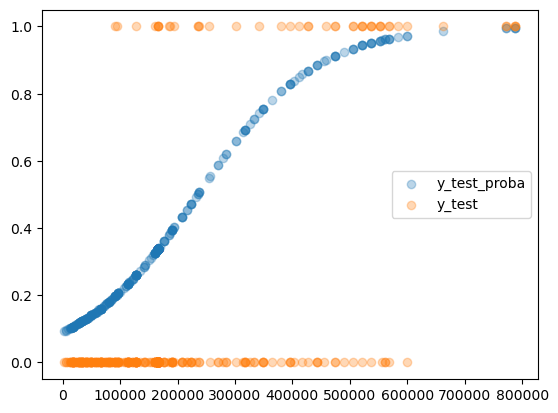

In [26]:
import matplotlib.pylab as plt
%matplotlib inline

ctf = cost_transform()
ctf.fit(train_raw,y_train)
plt.scatter(ctf.transform(test_raw,y_test), y_test_proba[:,1], alpha=0.3, label = 'y_test_proba')
plt.scatter(ctf.transform(test_raw,y_test), y_test, alpha=0.3, label = 'y_test')
plt.legend()

<font color='red'>Assignment:</font> Calculate **y_test_pred** using **predict** function. Plot **y_test_proba** versus **cost** and compare it with the plot of **y_test_pred** versus **cost**.

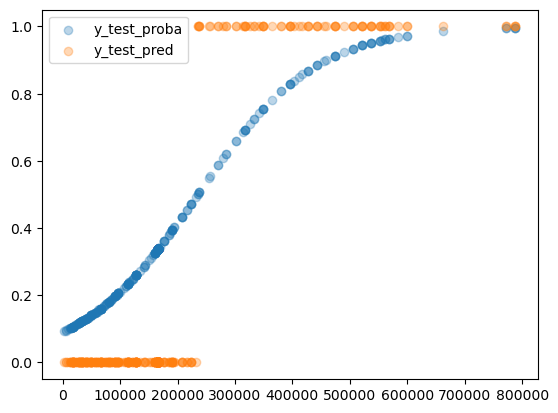

In [27]:
y_train_pred = model.predict(train_raw)
y_test_pred = model.predict(test_raw)

plt.scatter(ctf.transform(test_raw,y_test), y_test_proba[:,1], alpha=0.3, label = 'y_test_proba')
plt.scatter(ctf.transform(test_raw,y_test), y_test_pred, alpha=0.3, label = 'y_test_pred')
plt.legend()

<font color='red'>Question:</font> How can we transform **y_test_proba** to **y_test_pred**? What is the default threshold?

In [ ]:
# For each row, y_test_pred = 1 if y_test_proba[1] > 0.5, default threshold is 0.5 for binary classification.

<font color='red'>Assignment:</font> Change the threshold value applied in the transformation from **y_test_proba** to **y_test_pred**, and visualize how the threshold value changes **precision**, **recall**, and **f1 score**. 

(0.0, 1.0)

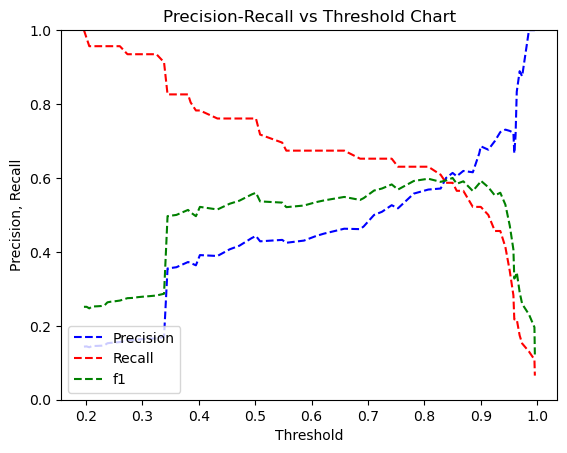

In [30]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.plot(thresholds, (2* recall[: -1] * precision[: -1]) / (recall[: -1] + precision[: -1]) , "g--", label="f1")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

<font color='red'>Question:</font> What threshold value would you like to choose? How do we decide which threshold to choose? Could you provide some examples?

In [ ]:
# A threshold near 0.8 is good based on the f1 value, 

<font color='red'>Question:</font> Is the threshold a hyper parameter? What kind of dataset should we use to find the threshold?

In [ ]:
# threshold is not a hyperparameter because it does not control how the model is trained. We could just use the test data set 
# to find the best threshold.

## 2.3 ROC AUC

<font color='red'>Assignment:</font> Calculate the train and test **roc_auc_score**s. 

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_train_proba[:, 1])

0.8540709119789114

In [32]:
roc_auc_score(y_test, y_test_proba[:, 1])

0.8788454989215575

<font color='red'>Question:</font> What do **ROC** and **AUC** stand for? 

In [ ]:
# ROC curve stands for recevier operating characteristic curve, which showing the performance of a classification model in all
# classification threshold. AUC stands for the area under the ROC curve.
# The ROC curve is plotted by connecting all the points of Ture positive rate (TPR) and False positive rate (FPR) at different
# classification threshold. TPR = TP / (TP + FN), FPR = FP / (FP + TN)

<font color='red'>Assignment:</font> Plot the ROC curve of test scores, use the **roc_curve** module in sklearn to obtain relevant data. 

In [34]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)

Text(0.5, 0, 'fpr')

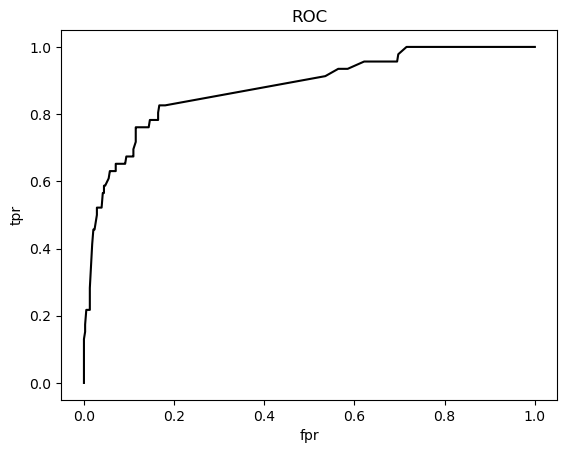

In [35]:
plt.title("ROC")
plt.plot(fpr, tpr, "k")
plt.ylabel("tpr")
plt.xlabel("fpr")

<font color='red'>Question:</font> What are the x and y axes? 

In [ ]:
# X axes is FPR value, y axes is TPR value.

<font color='red'>Question:</font> What is the range of **roc_auc_score**? What does it mean when **roc_auc_score** is greater than, equal to, or less than 0.5?

In [ ]:
# It is between 0 and 1, the value greater than, equal to or less than 0.5 mean the model perform better, euqal or worse than
# random guess, respectively.

## 2.4 Log Loss

**Knowledge:** The loss function for logistic regression is called **log loss** or **cross entropy**.

<font color='red'>Assignment:</font> Calculate the train and test log loss.

In [38]:
from sklearn.metrics import log_loss

train_log_loss = log_loss(y_train, y_train_proba)
test_log_loss = log_loss(y_test, y_test_proba)

print('train log loss: {0:.2e}'.format(train_log_loss))
print('test log loss: {0:.2e}'.format(test_log_loss))

train log loss: 4.59e-01
test log loss: 4.73e-01


<font color='red'>Question:</font> Which of these following terms are sensitive to base rates: **log loss**, **ROC AUC**, and **threshold**?

In [ ]:
# Both log loss and ROC AUC is sensitive to base rates. Threshold is a parameter independent of the data balances.

<font color='red'>Question:</font> If you are assigned to build a classification model to help increasing the response rate in direct mail marketing, what will be the target for you model? Which metrics will you use to evaluate the performance of your model?

In [ ]:
# I guess the base rate of response is much lower than 0.5. The target of the model is response (1) versus no-response (0). The 
# model should predict the response against un-response target so future mails should directed to the predicted 'response' 
# populations.
# We would like to increase the precision, which is TP / (TP + FP), in order to increasing the response rate, while minimize 
# the FN , so we don't miss too much customers.
# So precision is the major metric, recall and F1 is also considered.

# 3. Correlation between features and target

<font color='red'>Assignment:</font> Plot the distributions of **cost** values for positive and negative **luxury** items, respectively, in one figure. Use the data in the training set.

In [41]:
cost_train = ctf.transform(train_raw,y_train)

In [42]:
len(cost_train)

2757

In [44]:
cost_train_neg = cost_train.iloc[y_train.values == 0]
cost_train_pos = cost_train.iloc[y_train.values == 1]

In [45]:
len(cost_train_pos)

184

In [50]:
cost_train_pos.head()

,cost
17,631000.0
32,207000.0
55,185000.0
56,380000.0
119,270000.0


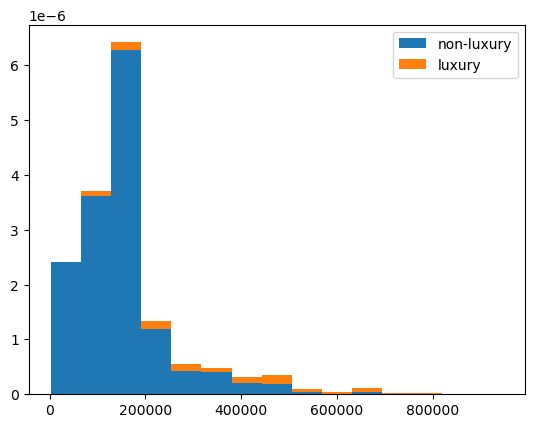

In [56]:
plt.figure()
plt.hist([cost_train_neg['cost'].values, cost_train_pos['cost'].values], bins=15, label = ['non-luxury', 'luxury'], stacked=True, density=True)
plt.legend()
plt.show()

<font color='red'>Question:</font> From the above figure, can you tell how good **cost** is a predictor for luxury?

In [ ]:
# Cost is relatively good predictor for luxury.

**Example:** Mannualy calculate the ROC AUC score of cost predictor. We can use this method to estimate the importance of a feature, before we use it in a model.

In [31]:
# preparation
train = cost_transformer().fit_transform(train_raw)
train['price'] = y_train
train.head()

,cost,price
0,333000.000000,0
1,166184.183143,0
2,270000.000000,0
4,97000.000000,0
5,59000.000000,0


In [32]:
# number of positive data points
num_pos = sum(train.price)
# number of negative data points
num_neg = len(train) - num_pos
# thresholds
ths = sorted(list(train.cost.unique()))

In [33]:
tprs = []
fprs = []
auc = 0.0
tpr0 = 1.0
fpr0 = 1.0
for th in ths:
    # true positive rates
    true_pos = sum(train[train['cost'] >= th]['price'])
    tpr = true_pos / num_pos
    tprs.append(tpr)
    
    # false positive rates
    false_pos = sum(train['cost'] >= th) - true_pos
    fpr = false_pos / num_neg
    fprs.append(fpr)
    
    # area under curve
    auc += (fpr0 - fpr) * (tpr0 + tpr)/2.0
    fpr0 = fpr
    tpr0 = tpr
    

Text(0, 0.5, 'true positive rate')

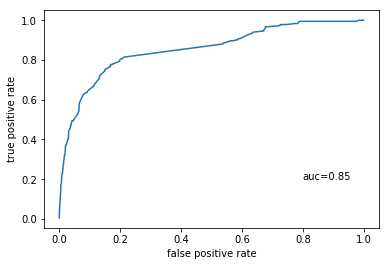

In [34]:
plt.plot(fprs, tprs)
plt.text(0.8, 0.2, 'auc={0:.2f}'.format(auc))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')